<a href="https://colab.research.google.com/github/Al-Tayeb96/Cirrhosis-Prediction-Project-4---Part-1-Core-/blob/main/Project_4_Part_1_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install collinearity

  Preparing metadata (setup.py) ... done
  Created wheel for collinearity: filename=collinearity-0.6.1-py3-none-any.whl size=4442 sha256=79ecad097ae8f217ba556db8e713272ca57354ad848ca743cdd3c305b1268698
  Stored in directory: /root/.cache/pip/wheels/0e/b1/ea/957b5269b023343361d1f3182a3bd03f8a6fbc86ce713ce7cb
Successfully built collinearity


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer,make_column_selector

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Setting options
n=800
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)
from sklearn import set_config
set_config(transform_output='pandas')


from collinearity import SelectNonCollinear

from sklearn.feature_selection import VarianceThreshold




#costume functions

In [5]:
"""UNIVARIATE PLOTTING FUNCTIONS FOR EDA"""
# Add the print statements to the function
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


# TO DO: add the new print statements from explore_categorical
def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes

In [6]:

"""MULTIVARIATE PLOTTING FUNCTIONS VS. NUMERIC TARGET"""

def plot_categorical_vs_target(df, x, y='rating',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  """Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  plt.show()

  return fig, ax


def plot_numeric_vs_target(df, x, y='rating',
                           figsize=(6,4),
                           ):
  """Plots a seaborn regplot with Pearson's correlation (r) added
  to the title.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]

  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  line_kws={'color':'red'}

  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws,line_kws=line_kws)

  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  # Make sure the plot is shown before the print statement
  plt.show()

  return fig, ax

In [7]:

def Feature_Inspection_categorical(df,use_cols,target_value):
  for cols in use_cols:
    if (df[cols].dtypes=='O'):
    # Confirming the dtype to select correct EDA function
      feature = cols
      df[feature].dtype
      # run the appropriate explore function (based on feature's dtype)
      print('\n')
      explore_categorical(df,feature);
      # Run the appropriate feature vs. target function (based on dtype)
      print('\n')
      plot_categorical_vs_target(df, feature,target_value)
      print('\n')
      print('\n')


def Feature_Inspection_numric(df,use_cols,target_value):
  for cols in use_cols:
   if (cols!= target_value):
    if (df[cols].dtypes=='int' or df[cols].dtypes=='float'):

       # Confirming the dtype to select correct EDA function
       feature = cols
       df[feature].dtype
       print('\n')
       # run the appropriate explore function (based on feature's dtype)
       explore_numeric(df,feature);
       print('\n')

       # Run the appropriate feature vs. target function (based on dtype)
       plot_numeric_vs_target(df,feature, target_value);
       print('\n')
       print('\n')


In [141]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict



#Data Preprocessing

In [142]:
# Load Data
df = pd.read_csv('/content/drive/MyDrive/ CodingDojo/Intermediate ML/cirrhosis.csv',index_col='ID')
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [143]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 1 to 418
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage     

Q1:What is the target? (You are required to complete a classification task for this project)
- Stage

Q2:What does one row represent? (A person? A business? An event? A product?)
- person

Q3:How many features does the data have?
- 20 fwatuers

Q4:How many rows are in the dataset?
- 418 ROWS

Q5: What opportunities exist for dimensionality reduction or feature selection with this dataset?
-Not strong, but relative


Q6: What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?
- MISSING VALUES
- duplicates
- constent fetuers
- collinearity
- overfiting / underfiting


In [144]:
# Check for null values
print('Number of NaN', df.isna().sum().sum())
print('Number of Duplicated Rows', df.duplicated().sum())
print('\n')


Number of NaN 1033
Number of Duplicated Rows 0




In [145]:
#convert age from days to years
df["Age"]=df['Age'].apply(lambda age: (age/365)).round(-1)
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,60.0,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,60.0,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,70.0,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,50.0,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,CL,Placebo,40.0,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [146]:
df.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,418.000000,418.000000,418.000000,284.000000,418.000000,310.000000,312.000000,312.000000,282.000000,407.000000,416.000000,412.000000
mean,1917.782297,50.765550,3.220813,369.510563,3.497440,97.648387,1982.655769,122.556346,124.702128,257.024570,10.731731,3.024272
std,1104.672992,10.988879,4.407506,231.944545,0.424972,85.613920,2140.388824,56.699525,65.148639,98.325585,1.022000,0.882042
min,41.000000,30.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1092.750000,40.000000,0.800000,249.500000,3.242500,41.250000,871.500000,80.600000,84.250000,188.500000,10.000000,2.000000
50%,1730.000000,50.000000,1.400000,309.500000,3.530000,73.000000,1259.000000,114.700000,108.000000,251.000000,10.600000,3.000000
75%,2613.500000,60.000000,3.400000,400.000000,3.770000,123.000000,1980.000000,151.900000,151.000000,318.000000,11.100000,4.000000
max,4795.000000,80.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,4.000000


##count
in counts ther is a diffrants in number of values that means the data set have a null values
## mean
averge of days between registration and the earlier of death, transplantation, or study analysis time in July 1986 is 1917, and the averge of patient ages is 50 and avrges for Clinic measurement is variability or dispersion that is indicating variability in patient conditions and responses to treatment.

##std
ther is a high variability in days between registration and the earlier of death, transplantation, or study analysis time in July 1986 , but for age has a low variability that means we have 95% of patient have ages between 30-70 years old and for Clinic measurement most of it has a variability or dispersion that is ensuring variability in patient conditions and responses to treatment and for target value "stages " we see from discribtion that most of patients 95% between 2-3 stages




In [147]:
df.isna().sum()

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [149]:
cat_cols = df.drop(["Stage"], axis=1).select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(exclude='object').columns.tolist()

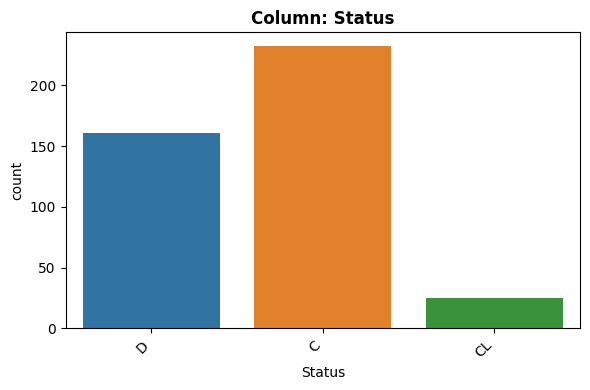

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'C' occurs 232 times (55.5%)
- Not constant or quasi-constant.




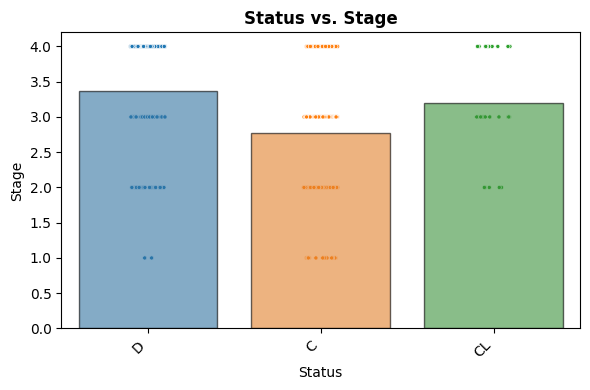

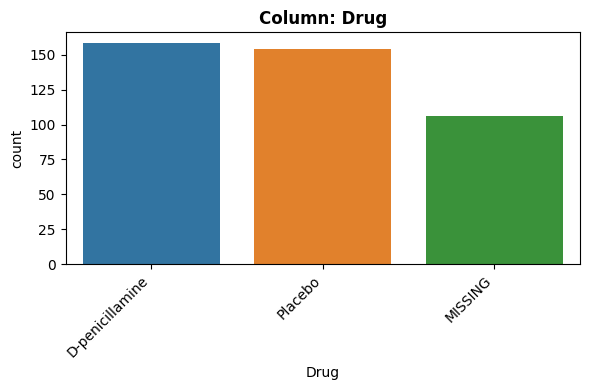

- NaN's Found: 106 (25.36%)
- Unique Values: 3
- Most common value: 'D-penicillamine' occurs 158 times (37.8%)
- Not constant or quasi-constant.




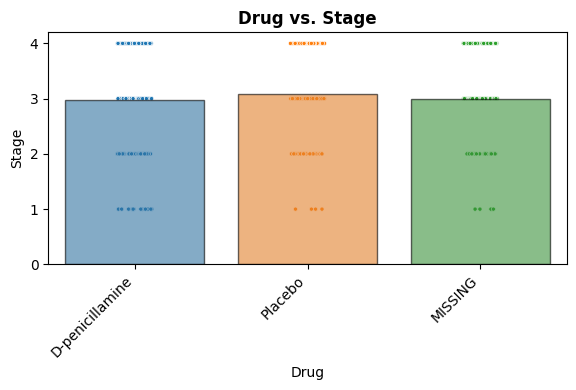

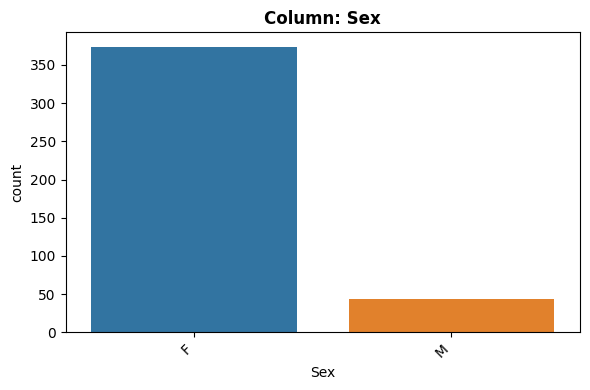

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'F' occurs 374 times (89.47%)
- Not constant or quasi-constant.




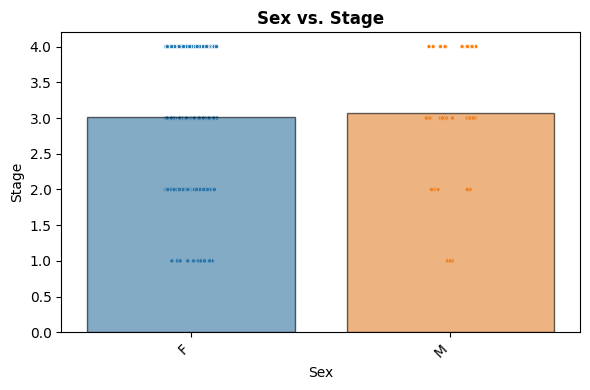

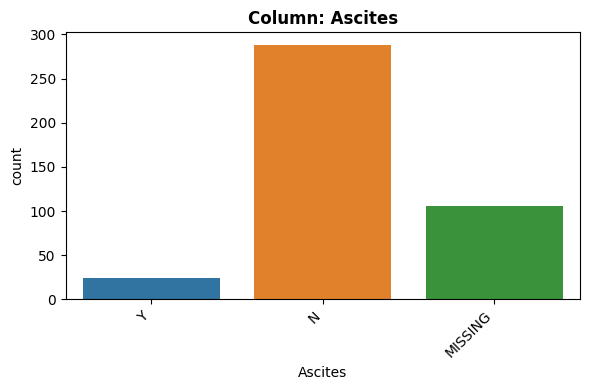

- NaN's Found: 106 (25.36%)
- Unique Values: 3
- Most common value: 'N' occurs 288 times (68.9%)
- Not constant or quasi-constant.




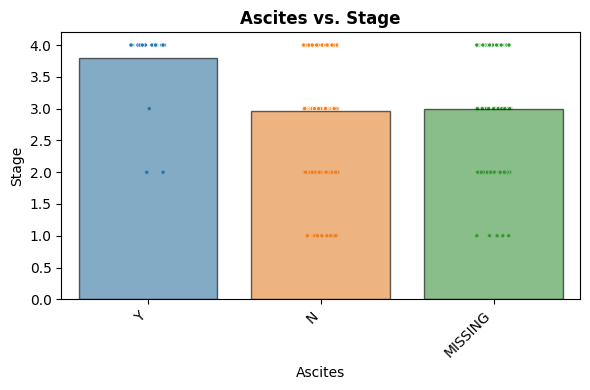

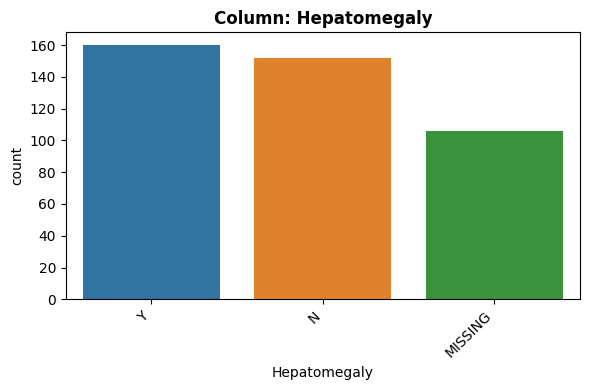

- NaN's Found: 106 (25.36%)
- Unique Values: 3
- Most common value: 'Y' occurs 160 times (38.28%)
- Not constant or quasi-constant.




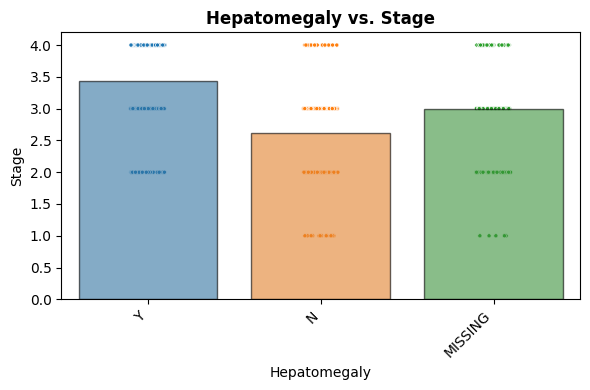

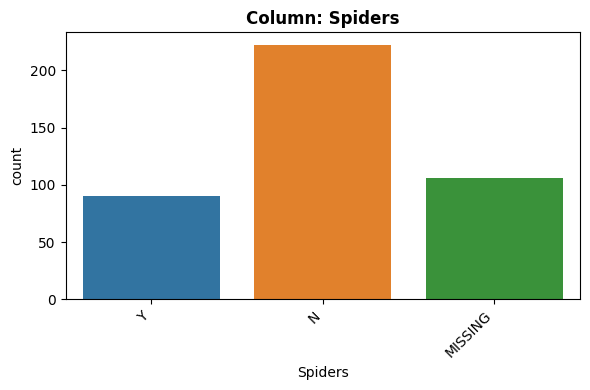

- NaN's Found: 106 (25.36%)
- Unique Values: 3
- Most common value: 'N' occurs 222 times (53.11%)
- Not constant or quasi-constant.




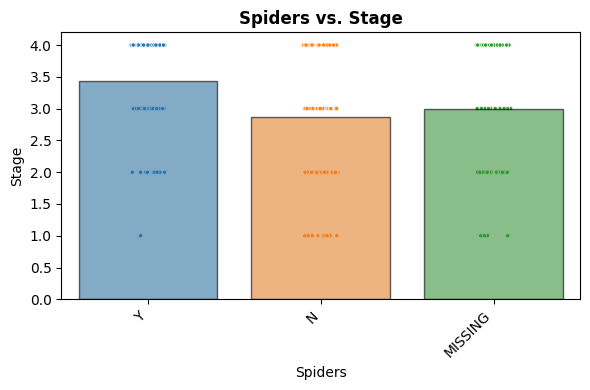

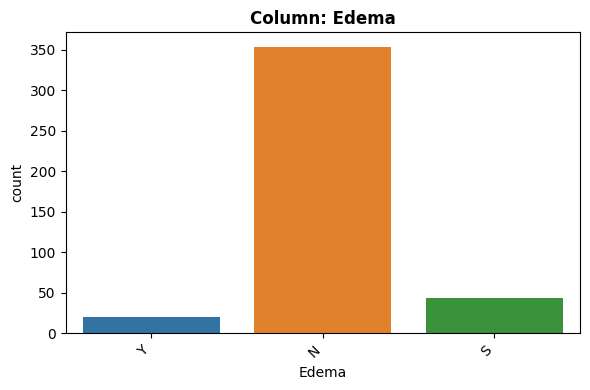

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'N' occurs 354 times (84.69%)
- Not constant or quasi-constant.




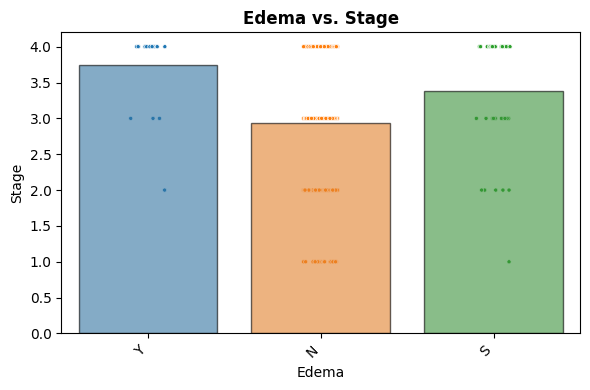

In [152]:
Feature_Inspection_categorical(df,cat_cols,"Stage")


**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - categorical (nominal)

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - sex:0
  - state:
  - druge:106 (25.36%)
  - ascites:106 (25.36%)
  - hepatomegaly:106 (25.36%)
  - spiders:106 (25.36%)
  - edema:0
  - Impute with "MISSING" placeholder.

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - 2-3 unique categories.
  - Not high cardinality (not >10)

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



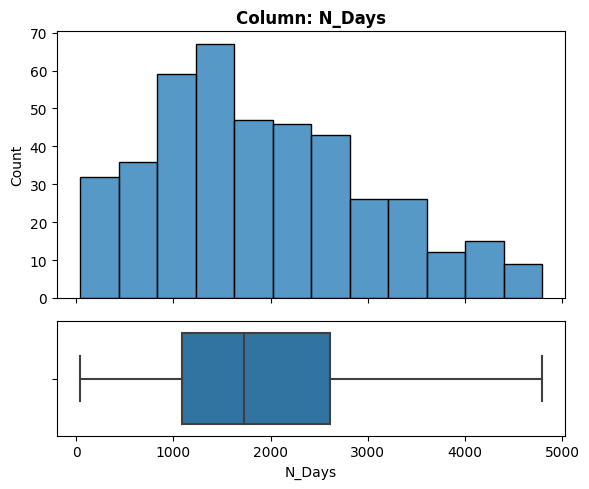

- NaN's Found: 0 (0.0%)
- Unique Values: 399
- Most common value: '1434' occurs 2 times (0.48%)
- Not constant or quasi-constant.




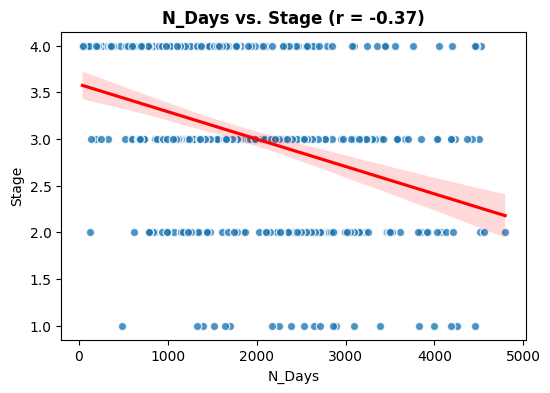

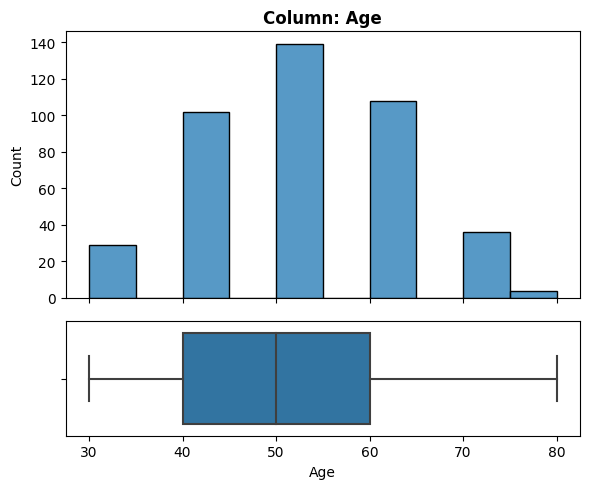

- NaN's Found: 0 (0.0%)
- Unique Values: 6
- Most common value: '50.0' occurs 139 times (33.25%)
- Not constant or quasi-constant.




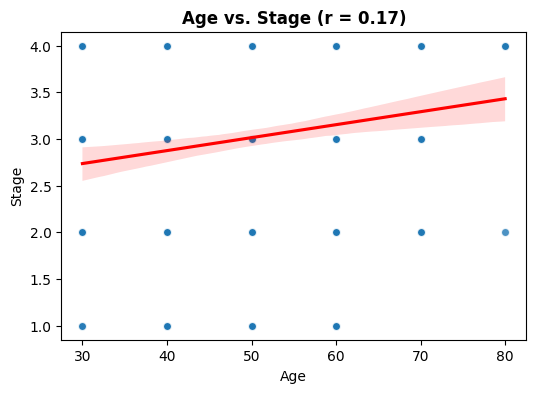

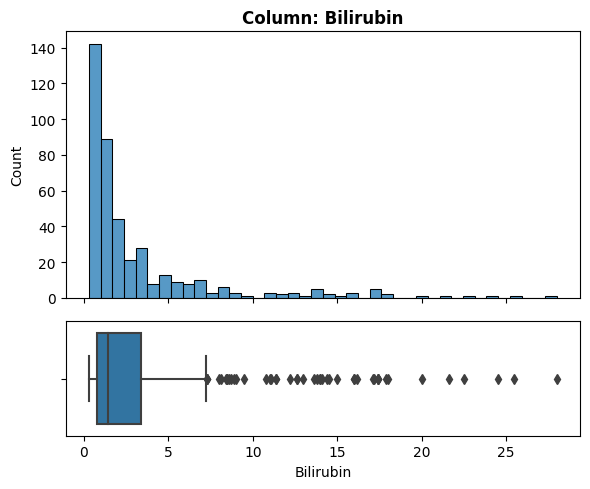

- NaN's Found: 0 (0.0%)
- Unique Values: 98
- Most common value: '0.7' occurs 33 times (7.89%)
- Not constant or quasi-constant.




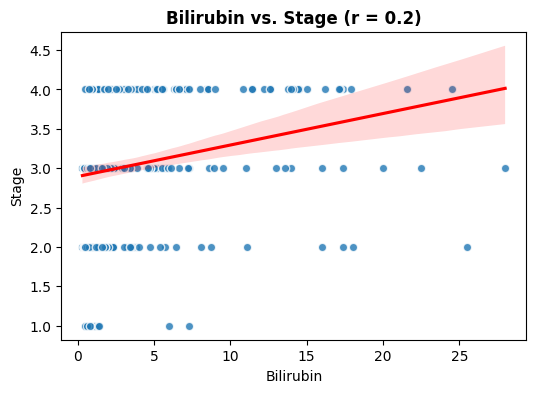

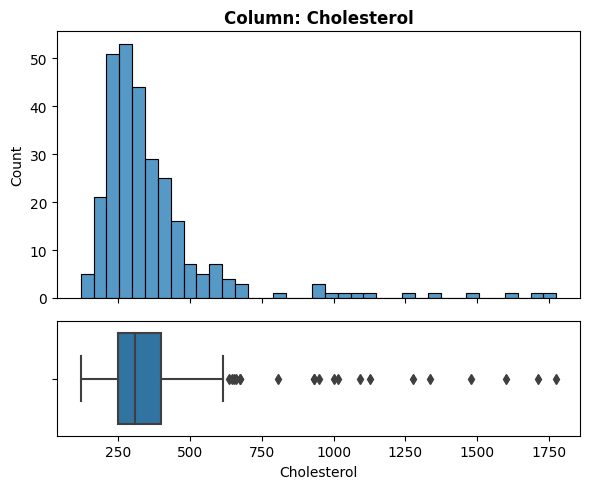

- NaN's Found: 134 (32.06%)
- Unique Values: 201
- Most common value: 'nan' occurs 134 times (32.06%)
- Not constant or quasi-constant.




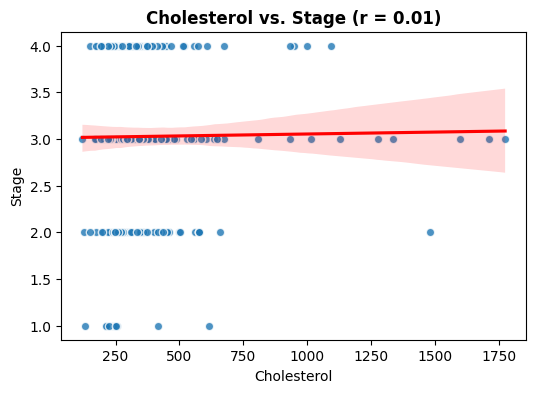

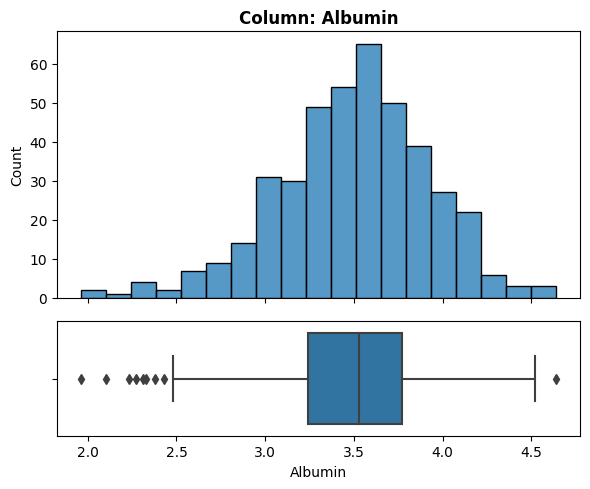

- NaN's Found: 0 (0.0%)
- Unique Values: 154
- Most common value: '3.35' occurs 11 times (2.63%)
- Not constant or quasi-constant.




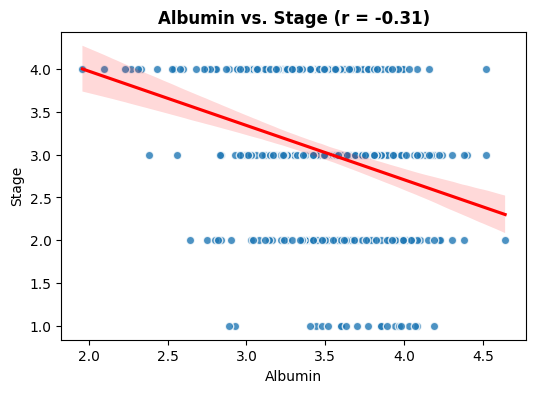

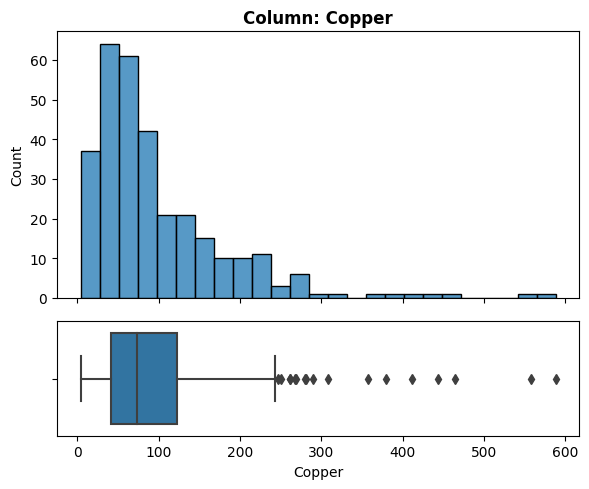

- NaN's Found: 108 (25.84%)
- Unique Values: 158
- Most common value: 'nan' occurs 108 times (25.84%)
- Not constant or quasi-constant.




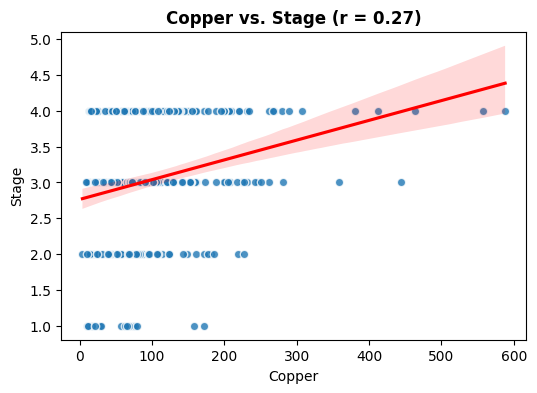

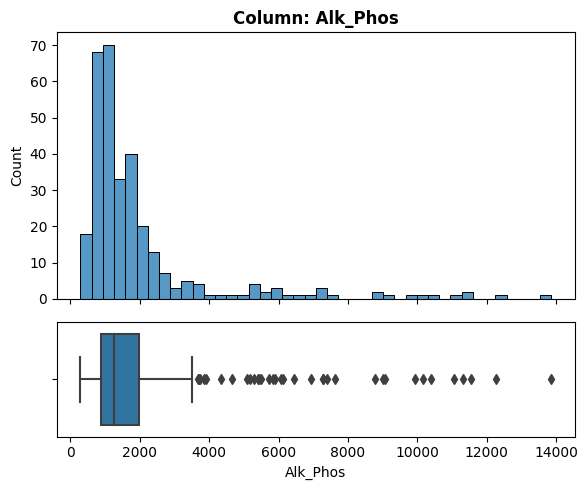

- NaN's Found: 106 (25.36%)
- Unique Values: 295
- Most common value: 'nan' occurs 106 times (25.36%)
- Not constant or quasi-constant.




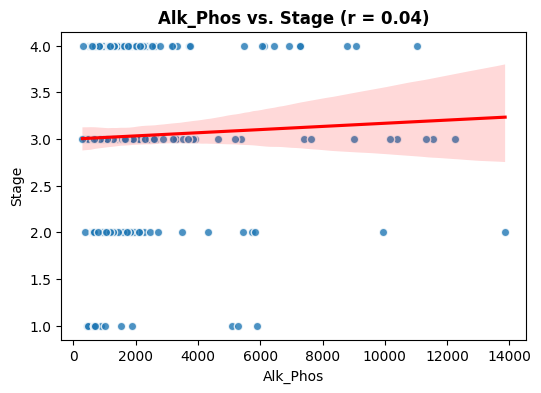

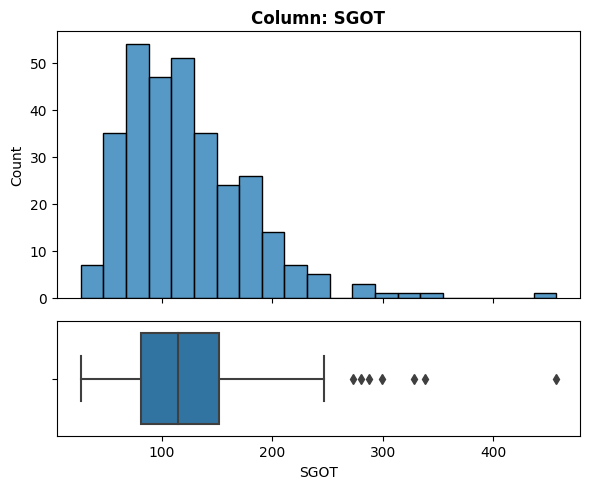

- NaN's Found: 106 (25.36%)
- Unique Values: 179
- Most common value: 'nan' occurs 106 times (25.36%)
- Not constant or quasi-constant.




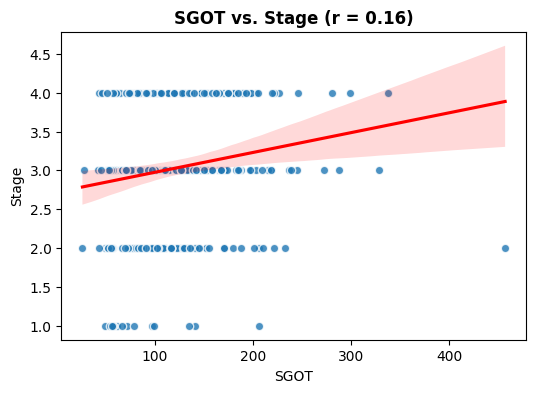

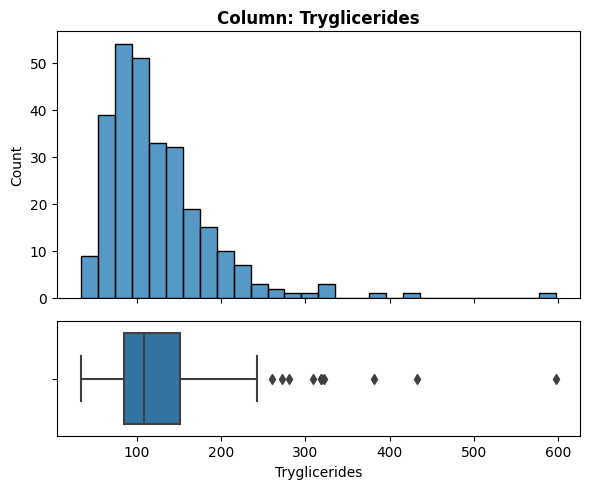

- NaN's Found: 136 (32.54%)
- Unique Values: 146
- Most common value: 'nan' occurs 136 times (32.54%)
- Not constant or quasi-constant.




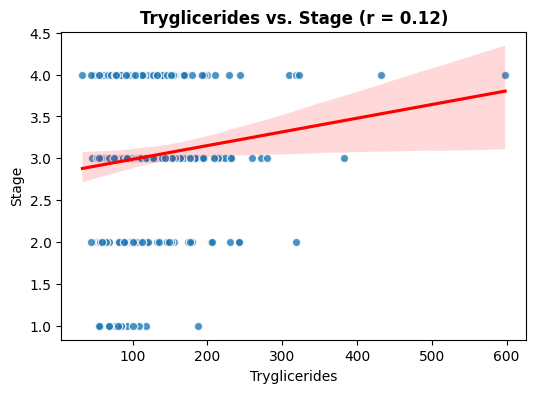

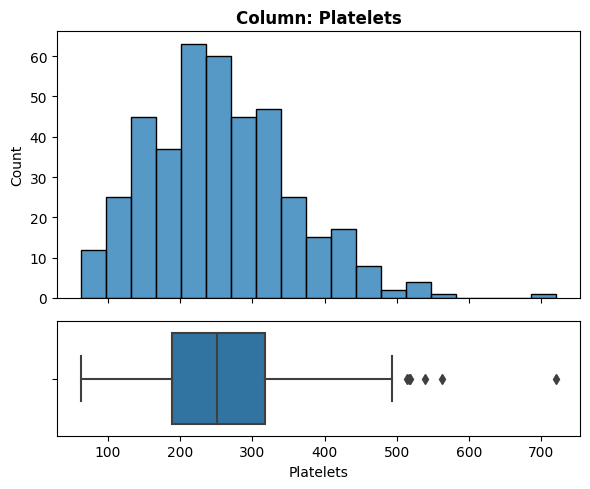

- NaN's Found: 11 (2.63%)
- Unique Values: 243
- Most common value: 'nan' occurs 11 times (2.63%)
- Not constant or quasi-constant.




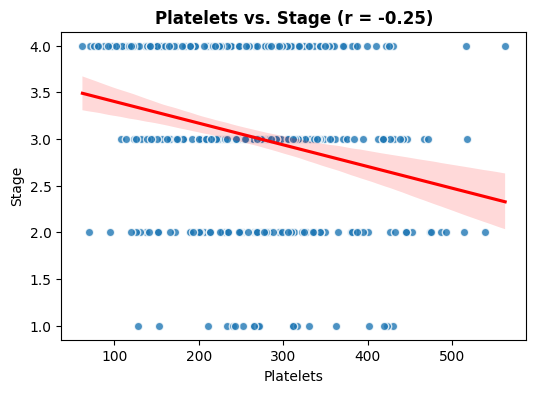

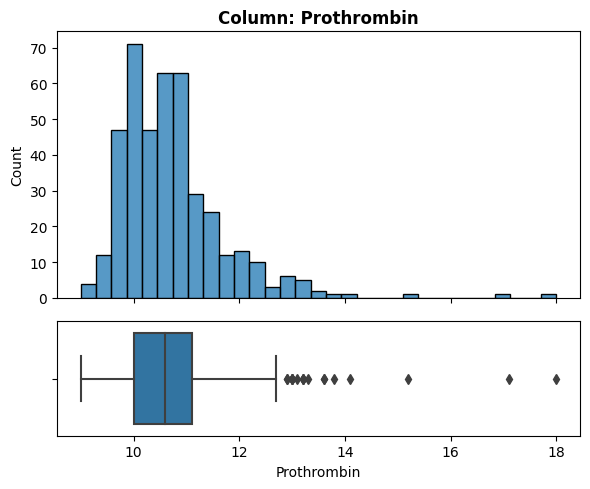

- NaN's Found: 2 (0.48%)
- Unique Values: 48
- Most common value: '10.6' occurs 39 times (9.33%)
- Not constant or quasi-constant.




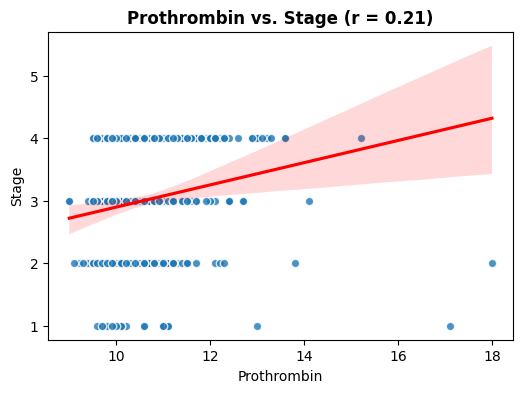

In [154]:
Feature_Inspection_numric(df,num_cols,"Stage")


**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - categorical (nominal)

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
 - 'N_Days':
 - 'Age':
 - 'Bilirubin':
 - 'Cholesterol':134 (32.06%)
 - 'Albumin':
 - 'Copper':108 (25.84%)
 - 'Alk_Phos':106 (25.36%)
 - 'SGOT':106 (25.36%)
 - 'Tryglicerides':106 (25.36%)
 - 'Platelets':11 (2.63%)
 - 'Prothrombin': 2 (0.48%)
  - drop it.

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Not applicable (numeric).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



<ipython-input-155-8db372dd2a69>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix =df.corr()


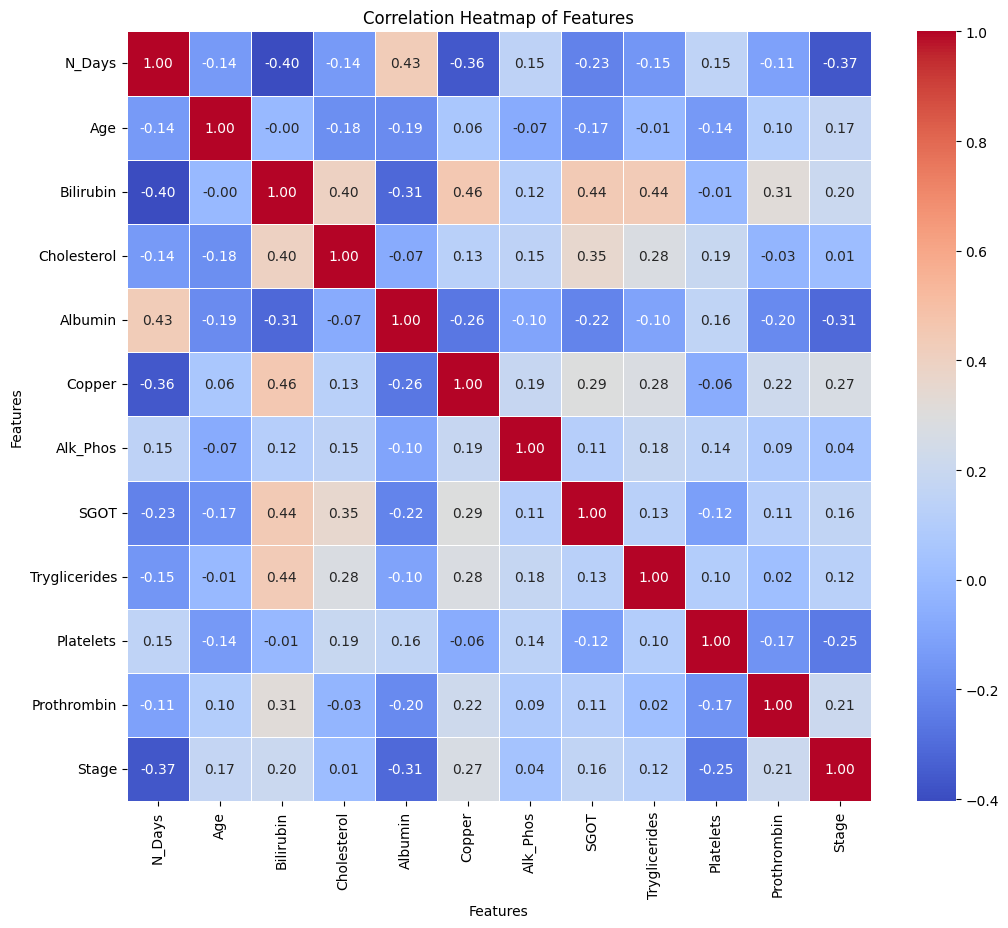

In [155]:
# Calculating correlation matrix
correlation_matrix =df.corr()

# Plotting a heatmap to visualize correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [184]:
correlation_matrix

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
N_Days,1.000000,-0.138311,-0.403953,-0.138236,0.430829,-0.364809,0.149269,-0.225492,-0.153000,0.151361,-0.111470,-0.366193
Age,-0.138311,1.000000,-0.004786,-0.181373,-0.194098,0.064011,-0.071170,-0.171510,-0.008316,-0.143857,0.101639,0.173561
Bilirubin,-0.403953,-0.004786,1.000000,0.397129,-0.314177,0.456918,0.116984,0.441730,0.436748,-0.013435,0.314894,0.200731
Cholesterol,-0.138236,-0.181373,0.397129,1.000000,-0.069733,0.126115,0.149473,0.353246,0.276830,0.191710,-0.030811,0.011164
Albumin,0.430829,-0.194098,-0.314177,-0.069733,1.000000,-0.264771,-0.101456,-0.220047,-0.103417,0.158659,-0.200592,-0.305296
Copper,-0.364809,0.064011,0.456918,0.126115,-0.264771,1.000000,0.187357,0.293829,0.279852,-0.064403,0.218224,0.269400
Alk_Phos,0.149269,-0.071170,0.116984,0.149473,-0.101456,0.187357,1.000000,0.112217,0.180082,0.143733,0.089384,0.041273
SGOT,-0.225492,-0.171510,0.441730,0.353246,-0.220047,0.293829,0.112217,1.000000,0.126119,-0.120147,0.112174,0.164945
Tryglicerides,-0.153000,-0.008316,0.436748,0.276830,-0.103417,0.279852,0.180082,0.126119,1.000000,0.103212,0.020122,0.123899
Platelets,0.151361,-0.143857,-0.013435,0.191710,0.158659,-0.064403,0.143733,-0.120147,0.103212,1.000000,-0.167331,-0.253523


-from corrlation heatmap it seems we have some fetuers with good corrlation acording the target value "Stage"
- fetuers with good corrlation:
  - Copper:0.27
  - Prothrombin:0.21
  - Bilirubin:0.20
- fetuers with slightly good corrlation:
 - SGOT:0.16
 - Age:0.17
 - Tryglicerides:0.12
- fetuers with weak corrlation:
  - N_Days
  - Platelets
  - Albumin




In [156]:
df=df.dropna()
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,60.0,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,60.0,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,70.0,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,50.0,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,CL,Placebo,40.0,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [157]:
df.isna().sum()

N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

#Model Building

In [159]:
# Define target
target_col = 'Stage'


# Define X and y
y = df[target_col].copy()
X = df.drop(columns=[target_col]).copy()

# Train test split
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=321)



In [160]:
X_train.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
ID,,,,,,,,,,,,,,,,,,
99,3820,C,Placebo,50.0,M,N,N,N,N,1.8,460.0,3.35,148.0,1472.0,108.50,118.0,172.0,10.2
113,980,D,D-penicillamine,50.0,F,N,Y,Y,N,6.7,374.0,3.74,103.0,979.0,128.65,100.0,266.0,11.1
231,1165,D,Placebo,60.0,F,N,Y,Y,N,3.4,518.0,1.96,115.0,2250.0,203.05,90.0,190.0,10.7
116,3336,C,D-penicillamine,60.0,F,N,N,Y,S,3.0,458.0,3.63,74.0,1588.0,106.95,382.0,438.0,9.9
115,3422,C,Placebo,40.0,F,N,N,Y,N,0.7,303.0,4.19,81.0,1584.0,111.60,156.0,307.0,10.3


In [161]:
X_train.isna().sum()

N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
dtype: int64

In [162]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline( ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
#________________________________________________________________________
# Numerical Prepprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
# instantiate preprocessors
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline( scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)

In [163]:
# Create the Column Transformer
prepprocessing=ColumnTransformer([num_tuple,ohe_tuple],verbose_feature_names_out=True)
prepprocessing

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))])

In [164]:
prepprocessing.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))])

In [165]:
# Transform the training data
X_train_processed = prepprocessing.transform(X_train)
# Transform the testing data
X_test_processed = prepprocessing.transform(X_test)
# View the processed training data
X_train_processed.head()



,numeric__N_Days,numeric__Age,numeric__Bilirubin,numeric__Cholesterol,numeric__Albumin,numeric__Copper,numeric__Alk_Phos,numeric__SGOT,numeric__Tryglicerides,numeric__Platelets,numeric__Prothrombin,categorical__Status_C,categorical__Status_CL,categorical__Status_D,categorical__Drug_D-penicillamine,categorical__Drug_Placebo,categorical__Sex_F,categorical__Sex_M,categorical__Ascites_N,categorical__Ascites_Y,categorical__Hepatomegaly_N,categorical__Hepatomegaly_Y,categorical__Spiders_N,categorical__Spiders_Y,categorical__Edema_N,categorical__Edema_S,categorical__Edema_Y
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
99,1.637206,0.086467,-0.334274,0.334583,-0.417319,0.522444,-0.245398,-0.310392,-0.121052,-0.973551,-0.535884,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
113,-0.874861,0.086467,0.734286,-0.013899,0.537888,0.008171,-0.514630,0.077172,-0.377615,0.017055,0.351540,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
231,-0.711222,1.028506,0.014644,0.569605,-3.821776,0.145311,0.179475,1.508178,-0.520151,-0.783861,-0.042871,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
116,1.209094,1.028506,-0.072586,0.326478,0.268471,-0.323250,-0.182049,-0.340205,3.641880,1.829653,-0.831692,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
115,1.285163,-0.855571,-0.574155,-0.301598,1.640051,-0.243252,-0.184234,-0.250767,0.420582,0.449128,-0.437281,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [166]:
y_train.value_counts()

3.0    83
4.0    70
2.0    44
1.0    10
Name: Stage, dtype: int64

In [167]:
from imblearn.over_sampling import SMOTE,SMOTENC
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train_processed , y_train)
y_train_sm.value_counts()

2.0    83
4.0    83
3.0    83
1.0    83
Name: Stage, dtype: int64

In [176]:
rf_cls = RandomForestClassifier(random_state = 321)
rf_cls.fit(X_train_sm, y_train_sm)

RandomForestClassifier(random_state=321)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        83
         2.0       1.00      1.00      1.00        83
         3.0       1.00      1.00      1.00        83
         4.0       1.00      1.00      1.00        83

    accuracy                           1.00       332
   macro avg       1.00      1.00      1.00       332
weighted avg       1.00      1.00      1.00       332



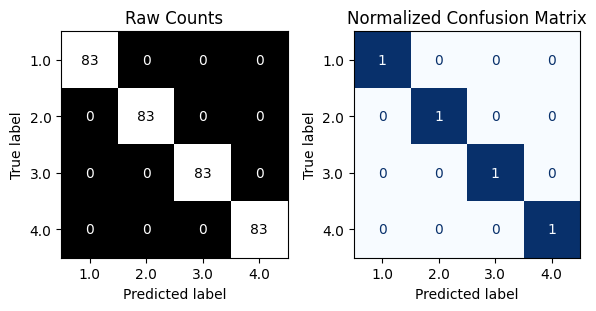


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         2
         2.0       0.36      0.33      0.34        15
         3.0       0.45      0.50      0.47        28
         4.0       0.67      0.58      0.62        24

    accuracy                           0.48        69
   macro avg       0.37      0.35      0.36        69
weighted avg       0.49      0.48      0.48        69



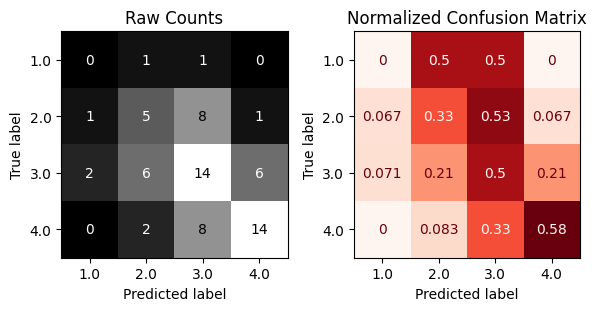

In [177]:
#use costum function to evaluate model befor pridctution
evaluate_classification(rf_cls, X_train_sm, y_train_sm, X_test_processed, y_test)

The model performs exceptionally well on the training data, achieving perfect precision, recall, and F1-score for all classes.
However, the model's performance on the test data is not as strong. It struggles particularly with Class 1.0, where it fails to predict any instances. The overall accuracy on the test data is lower, indicating the model's limited generalization to unseen data.

#important features

In [178]:
feature_names = prepprocessing.get_feature_names_out()
feature_importance = pd.Series(rf_cls.feature_importances_, index=feature_names,
                        name='logreg Feature Importances')
feature_importance.head()

numeric__N_Days         0.080809
numeric__Age            0.035146
numeric__Bilirubin      0.079719
numeric__Cholesterol    0.091284
numeric__Albumin        0.070099
Name: logreg Feature Importances, dtype: float64

## Apply sklearn's permutation importance and visualize the permutation importances.


In [180]:
from sklearn.inspection import permutation_importance

r = permutation_importance(rf_cls, X_train_processed, y_train ,n_repeats =5, random_state = 321)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [181]:
## can make the mean importances into a series
perm_importances = pd.Series(r['importances_mean'],index=X_train_sm.columns,
                           name = 'permutation importance')
perm_importances.head()

numeric__N_Days         0.010628
numeric__Age            0.000000
numeric__Bilirubin      0.007729
numeric__Cholesterol    0.021256
numeric__Albumin        0.007729
Name: permutation importance, dtype: float64

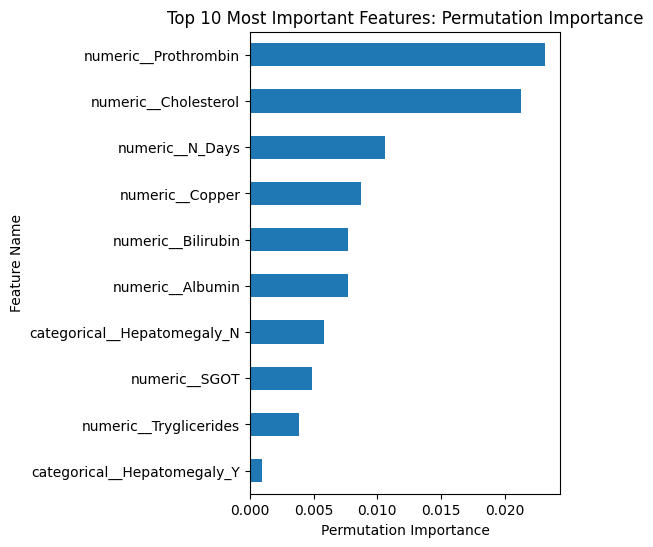

In [182]:
ax = perm_importances.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Permutation Importance',
       title='Top 10 Most Important Features: Permutation Importance');

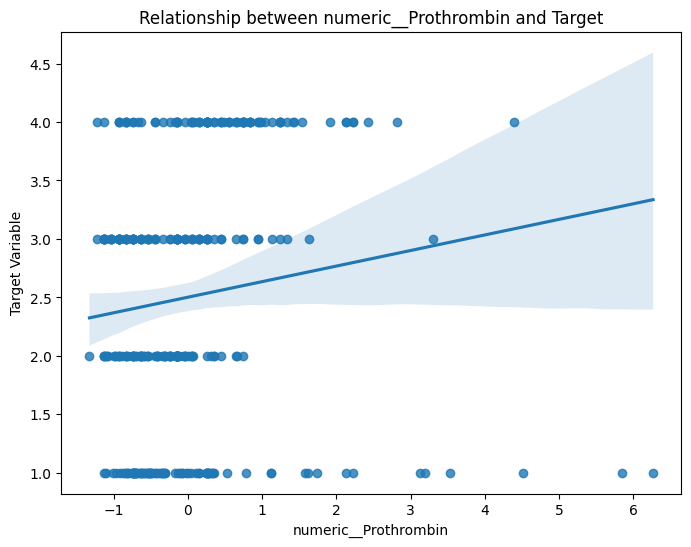

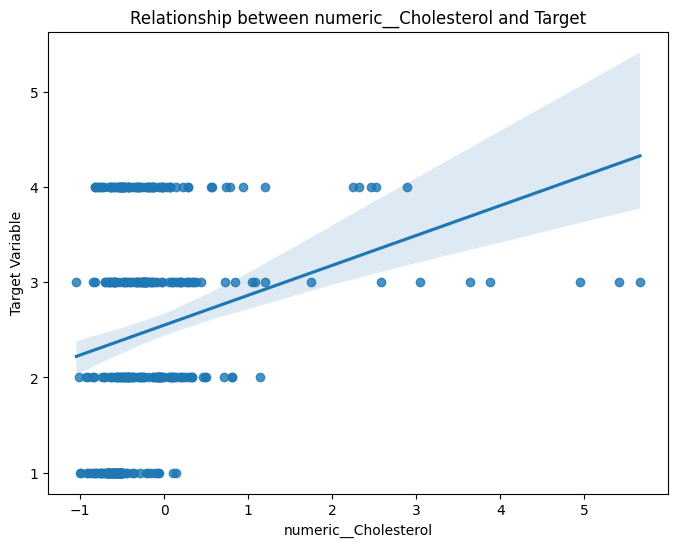

In [183]:
perm_importance = r

# Extract the top 10 features based on permutation importances
top_features_indices = perm_importance.importances_mean.argsort()[-10:][::-1]
top_features_names = X_train_sm.columns[top_features_indices]

# Select 2 out of the top 10 features
selected_features = top_features_names[:2]

# Create explanatory visualizations for the selected features
for feature in selected_features:
    # Scatter plot or other visualizations to show the relationship with the target
    plt.figure(figsize=(8, 6))
    sns.regplot(x=X_train_sm[feature], y=y_train_sm)
    plt.title(f"Relationship between {feature} and Target")
    plt.xlabel(feature)
    plt.ylabel("Target Variable")
    plt.show()

looks like this two faetuers have a postive relation with target value
so we can say if Cholesterol,Prothrombin are raised the pathological stage will be dangers